# Aplicando Python para análisis de precios: simulación de escenarios futuros de precios

<img style="float: right; margin: 0px 0px 15px 15px;" src="https://upload.wikimedia.org/wikipedia/commons/d/d7/Philippine-stock-market-board.jpg" width="400px" height="125px" />

> En la clase anterior vimos como importar datos de activos de la base de datos de Yahoo Finance usando el paquete pandas-datareader. En esta clase, veremos como pronosticar escenarios de evolución de precios, suponiendo que los rendimientos diarios se distribuyen normalmente. Como esta evolución de precios es aleatoria, utilizaremos la simulación montecarlo (hacer muchas simulaciones de escenarios de evolución de precios) para obtener probabilidades de que los precios de cierre estén encima de un valor umbral y tomar decisiones con base en estas probabilidades.

**Referencias:**
- http://pandas.pydata.org/
- http://www.learndatasci.com/python-finance-part-yahoo-finance-api-pandas-matplotlib/

## 1. Recordemos como descargar datos...

Antes que nada, para poder hacer simular escenarios de predicción de precios, vamos a recordar lo que hicimos en la clase pasada de descargar los datos de Yahoo Finance, utilizando el paquete `data` de la librería `pandas_datareader`.

Esta vez, utilizaremos los datos de precios de cierre ajustados de activos de la compañía Apple en el año 2016 para nuestra aplicación.

In [ ]:
# Instalación del paquete

# conda install pandas-datareader
# pip install pandas-datareader

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def getClose(names, start, end) :
    return yf.download(names, start= start, end = end)[["Adj Close"]]

In [4]:
aapl = getClose("AAPL", "2016-01-01", "2016-12-31")

[*********************100%%**********************]  1 of 1 completed


<Axes: ylabel='Frequency'>

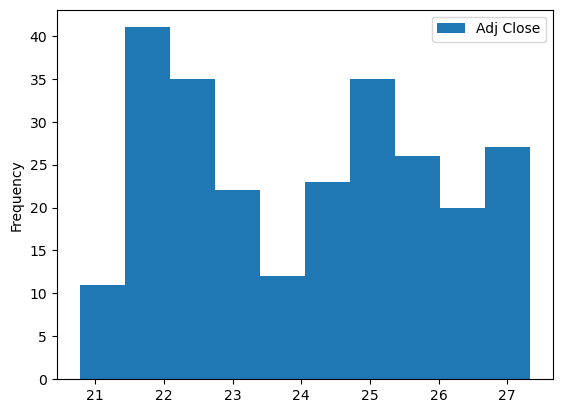

In [5]:
aapl.plot.hist()

## 2. Simulación de rendimientos diarios

Recordemos que los precios diarios de cierre ajustados no son un proceso estocástico estacionario, pero los rendimientos diarios si lo son. Por tanto calculamos los rendimientos a partir de los precios de cierre, obtenemos sus propiedades estadísticas muestrales y proyectamos los rendimientos. Luego, obtenemos la proyección de los precios.

Para una sucesión de precios $\{S_t\}_{t=0}^{n}$, el rendimiento simple $R_t$ se define como el cambio porcentual

$$
R_t=\frac{S_t-S_{t-1}}{S_{t-1}}\approx \ln\left(\frac{S_t}{S_{t-1}}\right)=r_t.
$$
para $t=1,\ldots,n$.

Para el ejemplo en curso, ¿cómo calcular esto?

Además, supusimos que los rendimientos diarios eran una variable aleatoria con distribución normal (que se caracteriza con su media y varianza). Por tanto obtenemos la media y desviación estandar muestrales. Hagamos una función que retorne lo anterior.

In [6]:
R = aapl.pct_change()

<Axes: ylabel='Frequency'>

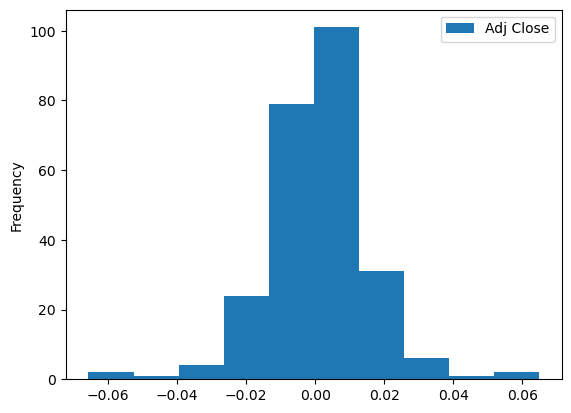

In [7]:
R.plot.hist()

Entonces, suponemos que el cambio porcentual de los precios (rendimientos diarios) tiene una distribución normal.

¿Cómo se caracteriza una [distribución normal](https://es.wikipedia.org/wiki/Distribuci%C3%B3n_normal)?

In [8]:
R.describe()

,Adj Close
count,251.000000
mean,0.000574
std,0.014731
min,-0.065707
25%,-0.005780
50%,0.000891
75%,0.007734
max,0.064963


In [9]:
R.mean()

Adj Close    0.000574
dtype: float64

In [10]:
R.std()

Adj Close    0.014731
dtype: float64

(array([ 6.,  8., 23., 39., 40., 49., 46., 23., 12.,  5.]),
 array([-0.04113267, -0.03299278, -0.02485289, -0.01671299, -0.0085731 ,
        -0.00043321,  0.00770668,  0.01584657,  0.02398646,  0.03212635,
         0.04026624]),
 <BarContainer object of 10 artists>)

<Figure size 640x480 with 0 Axes>

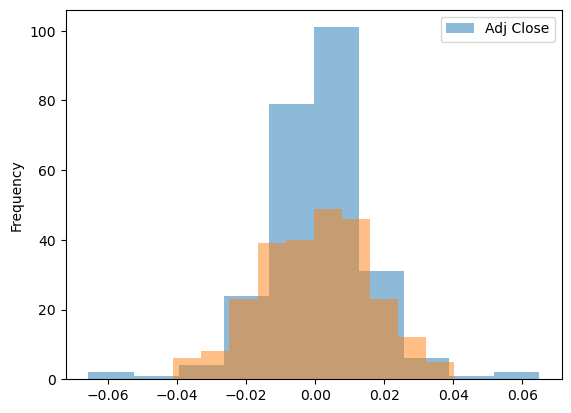

In [11]:
import numpy as np
sim_R = np.random.normal(R.mean(), R.std(), 251)

plt.figure()
R.plot.hist(alpha=0.5)
plt.hist(sim_R, alpha=0.5)

Habiendo caracterizado los rendimientos diarios como una variable aleatoria normal con la media y la varianza muestral obtenida de los datos desde 2016, podemos generar números aleatorios con estas características para simular el comportamiento de los precios de cierre de las acciones en el 2021 (hay un supuesto de que las cosas no cambiarán fundamentalmente).

Sin embargo, cada simulación que hagamos nos conducirá a distintos resultados (los precios siguen evolucionando aleatoriamente). Entonces, lo que haremos es simular varios escenarios para así ver alguna tendencia y tomar decisiones.

Hagamos una una función que simule varios escenarios de rendimientos diarios y que devuelva un dataframe con esta simulación.

In [12]:
def simR(media, std, start, dias, N) :
    sim_R = np.random.normal(media, std, size=(dias, N)) +1
    fechas = pd.date_range(start, periods= dias)
    return pd.pandas.DataFrame(sim_R, index=fechas)

In [13]:
aapl.iloc[-1]

Adj Close    26.912584
Name: 2016-12-30 00:00:00, dtype: float64

In [14]:
np.random.seed(5)
sim_R = simR(R.mean(), R.std(),"2017-01-01", 10,100)

In [15]:
sim_R.head(3)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
2017-01-01,1.007073,0.995699,1.036382,0.996860,1.002188,1.023885,0.987180,0.991858,1.003337,0.995714,...,1.017389,0.993182,0.999408,0.990367,0.991832,1.012185,0.994012,0.993471,1.007844,1.007946
2017-01-02,1.012247,1.003089,0.974739,1.009859,1.007914,1.015572,0.988104,1.037708,0.982419,1.011282,...,1.004254,1.017473,1.012888,1.004807,0.985907,1.013933,1.000930,0.997038,1.013980,1.009675
2017-01-03,1.007933,0.983610,0.991580,0.975473,1.003438,1.000990,1.014311,1.003697,0.995153,1.031678,...,0.987674,0.992647,0.981744,0.985949,1.017418,0.993074,1.013758,0.997978,1.005672,0.993115


In [47]:
precios_simulados = sim_R.cumprod()*26.912582
precios_simulados.tail()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
2017-01-06,27.936396,27.943491,27.816662,26.463435,27.397176,27.592432,27.042503,27.156185,25.767264,28.196247,...,27.184195,25.383133,26.043267,25.528345,26.759981,26.761372,27.583121,26.344614,27.905103,28.648382
2017-01-07,27.758731,27.919218,28.604692,25.799273,26.577903,27.192766,26.900369,26.712716,25.765680,28.175328,...,27.262341,25.795294,25.810577,25.716084,25.934852,26.354082,27.816466,26.731439,28.308860,29.116131
2017-01-08,27.104540,27.721104,27.533997,25.754827,26.685109,27.072344,26.548483,26.897042,25.982253,28.246937,...,27.082581,26.254016,25.894524,26.860268,25.825642,26.267914,28.777693,26.546631,29.262480,27.819591
2017-01-09,26.876721,28.331164,28.218326,25.964386,26.467312,27.055123,26.891232,27.061253,26.384656,27.988263,...,26.570419,26.462983,26.287491,27.033291,25.345460,26.078986,28.680415,26.744697,29.405998,27.675544
2017-01-10,26.240441,27.598831,27.827412,25.592737,26.244234,26.648257,26.852652,26.838572,26.480044,28.005717,...,26.426882,26.249696,25.888804,26.928100,25.646862,26.401046,29.023461,26.738424,29.560142,27.736939


In [49]:
precios_simulados.mean(axis=1)

2017-01-01    26.964311
2017-01-02    26.991354
2017-01-03    26.960020
2017-01-04    27.031980
2017-01-05    27.031001
2017-01-06    27.039187
2017-01-07    27.045059
2017-01-08    27.052862
2017-01-09    27.158428
2017-01-10    27.203874
Freq: D, dtype: float64

## 3. Proyección de precios de cierre

Por tanto, para calcular los precios, tenemos:

$$\begin{align}
p_i&=p_{i-1}(R_i+1)\\
p_{i+1}&=p_i(R_{i+1}+1)=p_{i-1}(R_i+1)(R_{i+1}+1)\\
&\vdots\\
p_{i+k}&=p_{i-1}(R_i+1)\cdots(R_{i+k}+1).
\end{align}$$

Si hacemos $i=0$ en la última ecuación, tenemos que $p_{k}=p_{-1}(R_0+1)\cdots(R_{k}+1)$, donde $p_{-1}$ es el último precio reportado en el 2018.

Con los rendimientos, calculamos los precios de cierre...

In [53]:
sim_R = simR(R.mean(), R.std(),"2017-01-01", 100,100000)
(sim_R*26.912582>28).mean(axis=1)

2017-01-01    0.00372
2017-01-02    0.00354
2017-01-03    0.00361
2017-01-04    0.00338
2017-01-05    0.00334
               ...   
2017-04-06    0.00364
2017-04-07    0.00372
2017-04-08    0.00357
2017-04-09    0.00327
2017-04-10    0.00377
Freq: D, Length: 100, dtype: float64

In [ ]:
26.912582

## 4. Probabilidad Precio-Umbral

Ya que tenemos muchos escenarios de precios proyectados, podemos ver varias cosas. Por ejemplo, ¿cuál es la probabilidad de que el precio de cierre sobrepase algún valor umbral en algún momento?

In [54]:
sim_R = simR(R.mean(), R.std(),"2017-01-01", 100,100000)
(sim_R*26.912582>28).mean(axis=1)

2017-01-01    0.00328
2017-01-02    0.00346
2017-01-03    0.00338
2017-01-04    0.00352
2017-01-05    0.00348
               ...   
2017-04-06    0.00337
2017-04-07    0.00368
2017-04-08    0.00367
2017-04-09    0.00329
2017-04-10    0.00338
Freq: D, Length: 100, dtype: float64

___
Entonces, ya aprendimos a bajar datos con pandas-datareader. En específico, a partir de los precios de cierre ajustados obtuvimos los rendimientos diarios.

Suponiendo que los rendimientos diarios son un proceso estocástico estacionario de distribución normal, pudimos caracaterizarlo y proyectar varios escenarios de evolución de los precios (montecarlo).

Con estas proyecciones pudimos calcular probabilidades de sobrepasar cierto precio umbral: toma de decisiones.